In [1]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [2]:
using DifferentialEquations
using Distributed
using Turing
using Distributions
using LinearAlgebra

using Plots
using StatsPlots

using Base.Threads
using Base.Threads: @spawn

# https://turing.ml/dev/docs/using-turing/guide


Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda$), where $c_0 = \frac{j_0}{\sqrt{Dk}}$ and $\lambda = \sqrt{\frac{D}{k}}$

MOL, Second-order central

https://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/

In [3]:
const Nc = 100
const L = 1.

const tissue = range(0,L,length = Nc)

const dx = step(tissue)
const h = 1/dx^2

const k = 1.
const j0 = 0.4

function morph_grad!(du,u,p,t)

    D = p

    du[1] = h*(2*u[2] + (2*dx*j0/D) - 2*u[1]) - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = h*(2*u[Nc-1] - 2*u[Nc]) - k*u[Nc]
    
end

morph_grad! (generic function with 1 method)

In [4]:
D = 0.16

p = (D)

u0 = zeros(Nc)

tspan = (0,12.)

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),save_everystep = false);

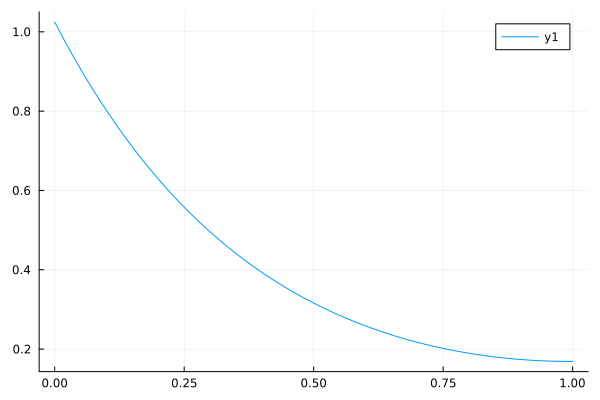

In [5]:
plot(tissue,sol.u[end])

In [6]:
# https://turing.ml/dev/tutorials/10-bayesian-differential-equations/

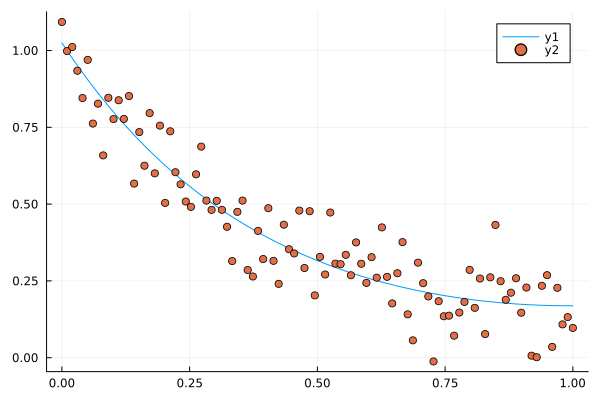

In [7]:
σ_noise = 0.3

d = Normal(0.0,σ_noise^2)

odedata = sol(tspan[2]) .+ rand(d,length(sol(tspan[2])))

plot(tissue,sol.u[end])
scatter!(tissue,odedata)

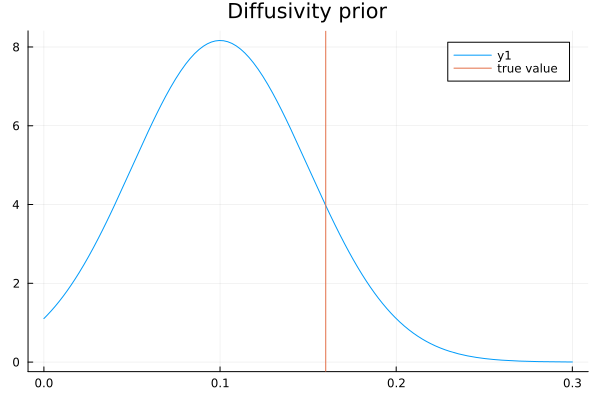

In [8]:
plot(truncated(Normal(0.1, 0.05); lower=0., upper=0.3),title = "Diffusivity prior")
vline!([D],label = "true value")

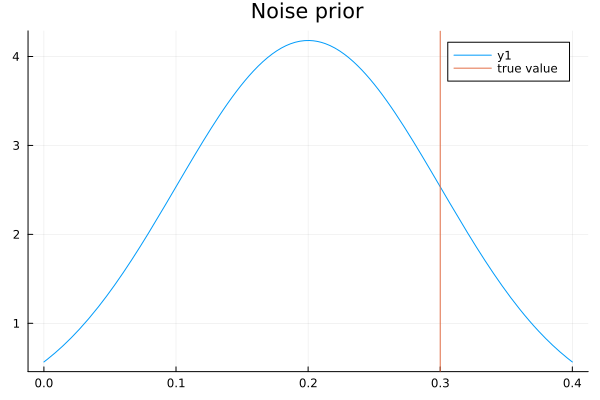

In [9]:
plot(truncated(Normal(0.2, 0.1); lower=0., upper=0.4),title = "Noise prior")
vline!([σ_noise],label = "true value")

In [12]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ truncated(Normal(0.2, 0.1); lower=0., upper=0.4)
    D ~ truncated(Normal(0.1, 0.05); lower=0., upper=0.5)

    # Simulate morphogen model. 
    p = (D)
    predicted = solve(prob, AutoTsit5(Rosenbrock23()); p=p, save_everystep = false).u[end]

    data = MvNormal(predicted, σ^2 * I)

    return nothing
end

fitlv (generic function with 2 methods)

In [13]:
model = fitlv(odedata, prob);

In [40]:
chain = sample(model, NUTS(0.65), MCMCSerial(), 1000, 1; progress=true)

Sampling (Chain 1 of 1)   0%|                           |  ETA: N/A


┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5960273357431407. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.029912303148826116. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.01038258465391889. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.004523052981976585. Aborting. There is either an error in your m

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.429152052064368e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.270992755137636e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.1756594774373867e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.1170020478386359e-6. Aborting. There is either an error in y

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.4957580870019686e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.8079842373057996e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0094789433777033e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:516
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.430933143619985e-10. Aborting. There is either an error in

In [1]:
plot(chain)

UndefVarError: UndefVarError: plot not defined